<a href="https://colab.research.google.com/github/farhadrgh/machine-learning/blob/master/Majorized_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Majorized Dictionary Learning

## Loading libs and data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving clockwork-angels.jpg to clockwork-angels.jpg


In [0]:
def dler(filename):
  from google.colab import files
  files.download('/content/%s' % filename)

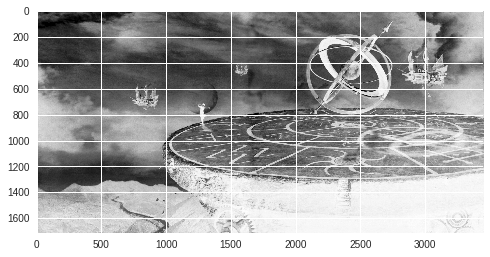

In [0]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, MiniBatchDictionaryLearning, SparseCoder
from sklearn.feature_extraction.image import extract_patches_2d

fname = "clockwork-angels.jpg"  
image = np.array(plt.imread(fname), dtype=np.int32)
red = image[:,:,0]

plt.imshow(red)

## Generating 1000 random patches (16,16)

In [0]:
patch_size = (16,16)
patches = extract_patches_2d(red,patch_size, max_patches=1000, random_state=1)
X = patches.reshape((1000,256))

np.save('X', X)

## Run PCA

In [0]:
t0 = time()
pca = PCA(n_components=np.min(X.shape), svd_solver='full')
pca.fit(X)
dt = time() - t0

W_pca = pca.components_
z_pca = pca.transform(X)

np.save('W_pca', W_pca)
np.save('z_pca', z_pca)

### Eigenvectors of patches (First 100 components)

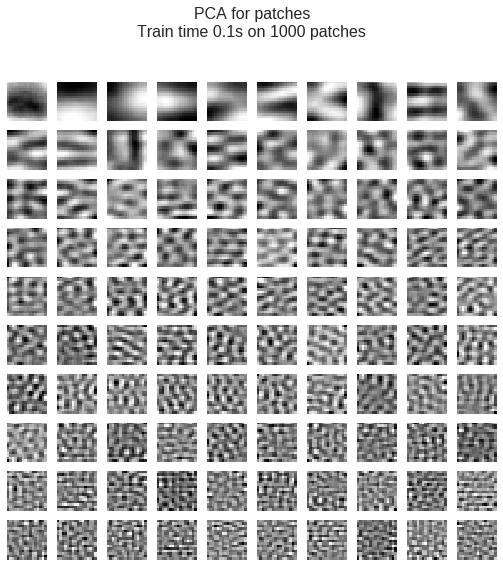

In [0]:
plt.figure(figsize=(8.2, 8))
for i, comp in enumerate(W_pca[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('PCA for patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(X)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

## Run Dictionary Learning

In [0]:
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=350)
dico.fit(X)
dt = time() - t0
print('done in %.2fs.' % dt)

W_dico = dico.components_   # (350,256)
z_dico = dico.transform(X).reshape((1000,350,1))    # (1000,350,1)

np.save('W_dico', W_dico)
np.save('z_dico', z_dico)

### Dictionary of patches (First 100 components)

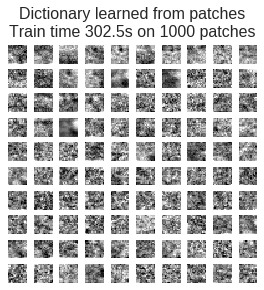

In [0]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(W_dico[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(X)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

##Majorizer

###Buggy Code

In [0]:
#files.download('/content/W.npy')
#files.download('/content/z.npy')

W = np.load('/content/W.npy')
z = np.load('/content/z.npy')

def getu(z):
  """get U (N,L,L) where Ui:diag{1/2/u_ik} (L,L), 
     pattern ith, k:1-L, z (N,L,1)"""
  
  eps = 1E-5
  z_abs = np.abs(z)

  u = np.maximum(z_abs, eps)  

  U = np.zeros((1000,350,350))
  for i in range(z.shape[0]):
    U[i] = np.diagflat(1./(2*u[i]))

  return U   # (1000,350,350)  

#getu(z)

def getz(W,X,U,lamda):
  """get z (N,L,1) where zi = (Wt W+lamda Ui)^-1 (Wt xi) (L,1)
     W (D,L), xi (D,1), X(N,D)"""
  
  N = U.shape[0]
  L = U.shape[1]
  D = X.shape[1]
  
  WtW = W.T @ W # (L,L)
  
  X_ten = X.reshape((N,D,1))
  z = np.zeros((N,L,1))
  WtX = np.zeros((N,L,1))
  
  for i in range(N):
    
    Arg = WtW - lamda*U[i]
    Arg_inv = np.linalg.inv(Arg) # (L,L)
    
    WtX[i] = W.T @ X_ten[i]
    z[i]   = Arg_inv @ WtX[i]
  
  return z

def objfxn(X,W,z,U,lamda):
  """X(N,D), W(D,L), z(N,L,1) U(N,L,L)"""
  N = U.shape[0]
  L = U.shape[1]
  D = X.shape[1]
  
  E = 0
  X_ten = X.reshape((N,D,1))
  
  for i in range(N):
    Arg1 = X_ten[i] - W @ z[i]
    norm = np.linalg.norm(Arg1)
    
    u_temp = np.diag(U[i]).reshape((L,1))    
    u_i = 0.5/u_temp
    Arg2 = lamda * 0.5 * np.sum((np.power(z[i],2) + np.power(u_i,2))/u_i)
    
    
    E += norm**2 + Arg2
   
  return E

def run(X,W,lamda):
  
  N = X.shape[0]
  L = W.shape[1]
  
  z = np.ones((N,L,1))
  U = getu(z)
  z = getz(W,X,U,lamda)
  
  count = 0
  obj_data = []
  obj_val = objfxn(X,W,z,U,lamda)
  obj_data.append([count, obj_val])
  while True:
    
    z_prev = z
    obj_prev = obj_val
    
    U = getu(z)
    z = getz(W,X,U,lamda)

    count += 1
    obj_val = objfxn(X,W,z,U,lamda)
    obj_data.append([count, obj_val])

    dist = abs(obj_val - obj_prev)   
    if dist < 1e-8:
      obj = np.array(obj_data)
      print("step: %3d obj: %f" % (count, obj_val))
      return z, obj
      break
    print("step: %3d diff: %f obj: %f" % (count, dist, obj_val))
    
#z, obj = run(X,W,lamda=1)

### Working Code

In [0]:
t0 = time()

W = np.load('/content/W_dico.npy')   # (L,D)
w = W.T
x = X.T # X(N,D), x(D,N)
T = 60  # max number of iterations
thresh = 10 ** (-8)  # optimization threshold of two consecutive iterations

# Parameters
lam = 1  # regularizer
epsilon = 1e-8  # epsilon threshold for u of majorizer
iter = 0

E = []  # saving objective values
delta_E = 100

# initialize u values

natoms = 350  # Number of atoms

u = np.ones([x.shape[1], natoms])  # majorizer variables
z = np.zeros([x.shape[1], natoms])

wtw = w.T@w  # size of natoms by natoms
wtx = w.T@x  #

while delta_E > thresh and iter < T:
    if iter % 10 == 0:
        print("Iterations %d" % iter)
    # update z values
    # z = wtw @(wtx - 0.5/u)
    for i in range(x.shape[1]):
        U = np.diag(1/(2*u[i]))
        temp = np.linalg.inv(wtw+lam*U)@ w.T @ x[:, i]
        z[i] = temp.reshape((natoms,))

    #     z[i] = wtw@ (w.T * x[i] - 0.5/u[i])

    # update u: majorizer variables
    u = np.abs(z)
    u[u < epsilon] = epsilon

    # Computing Objective Function
    diff = x - w @ z.T
    term_1 = np.sum(np.sum(diff.T@diff, axis=0))
    term_2 = lam * 0.5 * np.sum((np.power(z, 2) + np.power(u, 2))/u)

    e = term_1 + term_2

    E.append(e)

    if iter > 0:
        delta_E = np.abs(E[iter] - E[iter - 1])  # / E[iter - 1]

    iter += 1
dt = time() - t0
    
np.save('z_maj', z)
# W was fixed, from W_dict
np.save('obj_maj', E)

Iterations 0
Iterations 10
Iterations 20
Iterations 30
Iterations 40
Iterations 50


### Majorized Objective Function

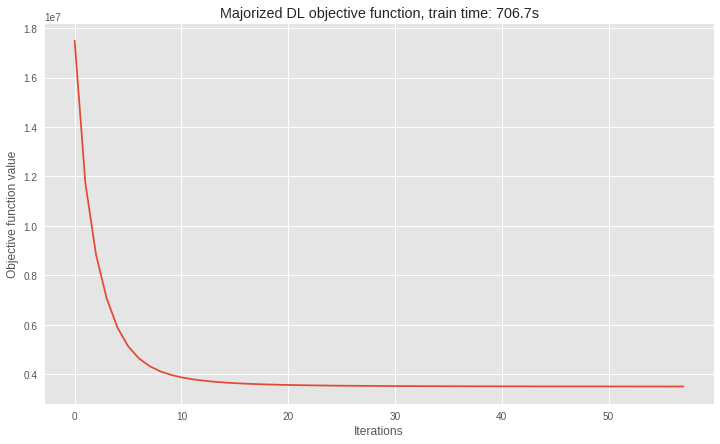

In [0]:
plt.style.use('ggplot')
z_maj = np.load('/content/z_maj.npy')
obj_maj = np.load('/content/obj_maj.npy')

fig, ax = plt.subplots(figsize=(12, 7))
Iter = [i for i in range(iter)]

ax.plot(obj_maj[2:])
ax.set_xlabel('Iterations')
ax.set_ylabel('Objective function value')
ax.set_title('Majorized DL objective function, train time: %.1fs' % (dt))
plt.show()

###Compare Majorizer with SPAM or sparescoder

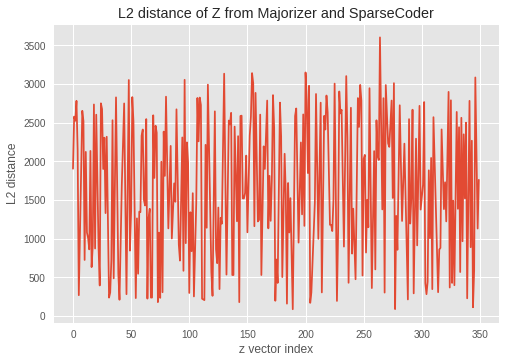

In [0]:
def L2diff(z):
  diff = [np.linalg.norm(z_maj[i]-z[i]) for i in range(z.shape[1])]
  plt.plot(diff)
  plt.xlabel('z vector index')
  plt.ylabel('L2 distance')
  plt.title('L2 distance of Z from Majorizer and SparseCoder')

W_dico = np.load('/content/W_dico.npy')
sparse = SparseCoder(W_dico)
sparse.fit(X)
z_sparse = sparse.transform(X)
np.save('z_sparse', z_sparse)
L2diff(z_sparse)

## Reconstruction Errors

###PCA

In [0]:
W_pca = pca.components_  #(D,D)
z_pca = pca.transform(X) #(N,D)  X(N,D)
e_pca = X - z_pca @ W_pca
error_pca = 0.001*np.sum(np.linalg.norm(e_pca, axis=1)**2)
error_pca


4137570.369204

###Dictionary Learning

In [0]:
W_dico = dico.components_  # (L,D)
z_dico = dico.transform(X) # (N,L)
e_dico = X - z_dico @ W_dico
error_dico = 0.001*np.sum(np.linalg.norm(e_dico, axis=1)**2)
error_dico

7591.364770823823

### Majorizer

In [0]:
W_dico = np.load('/content/W_dico.npy')
z_maj = np.load('/content/z_maj.npy')
e_maj = X.T - W_dico.T @ z_maj.T
error_maj = 0.001*np.sum(np.linalg.norm(e_maj, axis=0)**2)
error_maj

111.43929862625583

### SparseCoder

In [0]:
W_sparse = sparse.components_    # (L,D)
z_sparse = sparse.transform(X)   # (N,L)
e_sparse = X - z_sparse @ W_sparse
error_sparse = 0.001*np.sum(np.linalg.norm(e_sparse, axis=1)**2)
error_sparse

7591.364770823823